    # Odovzdanie 2 - Predspracovanie
#### Anton Rusňák, František Gič

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms
import scipy.stats as stats
import statistics 
from statistics import mode 
%matplotlib inline
pd.set_option('display.max_rows', 1000)

Nacitanie pomocnych funkcii zo skriptu

In [2]:
%run "functions.py"

### Nacitanie datasetov 

In [3]:
data_personal = load("data/personal_train.csv")
data_other = load("data/other_train.csv")

print(len(data_personal))
print(len(data_other))

3933
3983


### Spajanie datasetov

In [4]:
data = pd.merge(data_personal,data_other,on=['name','address'], how = 'outer')

print(len(data))

3983


### Predspracovanie jednotlivych atributov

#### Atribut sex

Neobsahuje ziadne prazdne hodnoty, len stripneme whitespace a nahradime kategoricke hodnoty ich ciselnymi reprezentaciami - 1 (Male) a 0 (Female)

In [5]:
print(len((data[data.sex.isnull()])))

0


In [6]:
def sanitize_sex(sex):
    return 1 if sex.strip() == 'Male' else 0

In [7]:
data.sex = data.sex.map(lambda sex: sanitize_sex(sex))

In [8]:
data.sex.unique()

array([1, 0], dtype=int64)

#### Atribut age<br>
Ako aj v prvom odovzdani spracuvame age na ciselny atribut a jeho zaporne hodnoty nahradime NaN

In [9]:
data.age = data.age.map(sanitize_age)

In [10]:
len(data[pd.isnull(data.age)])

756

Po spracovani vsak mame vela prazdnych hodnot (756).<br>
Napada nas sposob vypocet nahradenim podla datumu, ale nemame zatial rozparsovany atribut date of birth.
<br>

Mohli by sme nahradit chybajuce hodnoty pacienta priemerom veku jeho pohlavia.
Pokial by pacient nemal uvedene pohlavie, nahradili by sme primerom vsetkych pacientov. Tuto funkciu si naprogramujeme, a uvidime ci sa bude dat pouzit neskor.

In [11]:
def fill_null_age(data): 
	unique_sexes = data.sex.unique()
	for sex in unique_sexes:
		mean = data.loc[(data.age.notnull()) & (data.sex == sex)].age.mean()
		data.loc[(data.sex == sex) & (data.age.isna()),'age'] = mean
	return data	

#### Atribut pregnant<br>
Upravime boolean hodnoty a nahradime ich ciselnou reprezentaciou.
<br>Taktiez vsetkym muzom nastavime pregnant na 0

In [12]:
def sanitize_boolean(boolean):
    try:
        if boolean.strip() in ['f','F','FALSE','false','False']:
            return 0
        elif boolean.strip() in ['t','T','TRUE','true','True']:
            return 1
        else:
            return np.nan
    except AttributeError:
        return np.nan

In [13]:
data.pregnant = data.pregnant.map(sanitize_boolean)

In [14]:
def sanitize_pregnancy(data):
	data.loc[(data.sex == 1),'pregnant'] = 0
	return data

data = sanitize_pregnancy(data)	

Po vycisteni atributu pregnant by sme mohli v pripade ak nejaky zaznam ma chybajuci atribut sex a zaroven ma pregnant 1 -  nastavit ako sex ako zenu (0).
V tomto datasete take nemame, ale je dobre pripravit nasu funkciu just in case.

In [15]:
def sanitize_pregnancy(data):
	data.loc[(data.sex == 1),'pregnant'] = 0
	data.loc[(data.sex.isnull()) & (data.pregnant == 1),'sex'] = 0
	return data

data = sanitize_pregnancy(data)	

Vidime ze v datasete mame aj prazdne hodnoty, budeme sa tym zaoberat neskor

In [16]:
print(data.pregnant.unique())
data.pregnant.isnull().sum()

[ 0.  1. nan]


1

#### Atribut personal info<br>
Vyparsujeme vsetky hodnoty z tohto stringu a vytvorime nove columny

In [17]:
parsed_info = data.personal_info.map(parse_personal_info).map(remove_empty)

In [18]:
personal_info_columns = ['employment','country','relationship_info','employment_info','race']
for index,name in enumerate(personal_info_columns):
    data[name] = parsed_info.map(lambda x: fill_value(index,x))
	
data = data.drop('personal_info', axis=1)

In [19]:
data[personal_info_columns].head(5)

,employment,country,relationship_info,employment_info,race
0,Transport-moving,United-States,Divorced,Private,White
1,Adm-clerical,United-States,Divorced,Private,White
2,Prof-specialty,United-States,Married-civ-spouse,Private,White
3,Prof-specialty,United-States,Married-civ-spouse,State-gov,White
4,Tech-support,United-States,Never-married,Private,White


#### Atribut date of birth<br>
Z prvotnej analyzy vieme ze date of birth nema unifikovany tvar datumu, cize bude nutne ho osetrit.

In [20]:
def sanitize_date(date):
    date = str(date).replace('/', '-')
    date = date[:10]
    date = date.split("-")
    
    if date[0] != 'nan':
        if len(date[0]) != 4:
            if len(date[2]) == 2 and int(date[0]) > 31:
                new_date = "19"+ date[0] +"-"+date[1]+"-"+date[2] 
                
            elif ((len(date[2]) == 2) and (int(date[0]) < 31) and (int(date[2]) > 31)):
                new_date = "19"+date[2]+"-"+date[1]+"-"+date[0] 
                
            elif ((len(date[2]) == 2) and (int(date[0]) < 31) and (int(date[2]) < 31)):
                new_date = "20"+ date[2] + "-" +date[1]+"-" + date[0] 
            else:
                new_date = date[2]+"-"+date[1]+"-"+date[0] 
            return new_date        
    return '-'.join(date)

In [21]:
data.date_of_birth = data.date_of_birth.map(sanitize_date)
data.date_of_birth.head(5)

0    1960-07-04
1    1972-07-20
2    1960-02-28
3    1967-12-04
4    1938-04-22
Name: date_of_birth, dtype: object

Vidime, ze datumy maju uz rovnaky format. Teraz sa mozme vratit k upravovaniu atributu age - vypocitat chybajuce hodnoty na zaklade datumu.

### Dopocitanie veku na zaklade datumu

Prejdeme vsetky datumy a najdeme najfrekventovanejsi rok po scitani veku a roku narodenia. To je rok, v ktorom bolo uskutocnene meranie (supis) veku.
Tento rok vyuzijeme na dopocitanie veku osob na zaklade ich datumu narodenia ktore ho nemaju.

In [22]:
years = [];

def store_measure_year(age,date):
    if (pd.notnull(age)):
        years.append(int(date.split('-')[0]) + age)
        
data.apply(lambda x: store_measure_year(x.age,x.date_of_birth),axis=1)

measure_year = pd.Series(years).mode();

In [23]:
def fill_null_age(age,date):
    if (date):
        return (measure_year - int(date.split('-')[0]))[0]
    return np.nan

data.loc[data.age.isnull(),'age'] = data[data.age.isnull()].apply(lambda x: fill_null_age(x.age,x.date_of_birth),axis=1)

Podarilo sa nam vsetkym zaznamom dopocitat vek.

In [24]:
len(data[data.age.isnull()])

0

Nastastie nemame ziadne take ze bez datumu a bez veku.

In [25]:
len(data[(data.date_of_birth.isna()) & (data.age.isnull())])

0

#### Atribut income
Prehodime kategoricke hodnoty na ciselnu reprezentaciu ('<=50K' == 0, '>50K' == 1)

In [26]:
data.income.unique()

array([' <=50K', ' >50K', nan], dtype=object)

In [27]:
data.income = data.income.map(lambda income: 0 if str(income).strip() == '<=50K' else 1 if str(income).strip() == '>50K' else np.nan)

In [28]:
data.income.unique()

array([ 0.,  1., nan])

#### String Atributy
Tieto atributy su stringove, viackrat duplicitne, skusime ich troska quickfixnut a zjednotit data

In [29]:
def strip_string(string):
    try:
        return str(string).strip()
    except AttributeError:
        return None

def sanitize_string(string):
    string = strip_string(string);
    if string in ['None','nan','??','?']:
        return None
    return string

def sanitize_multiword_string(string):
    try:
        return sanitize_string(string).replace('-',' ').replace('_',' ')
    except AttributeError:
        return None

for column in ['relationship','relationship_info','employment','employment_info']:
    data[column] = data[column].map(sanitize_multiword_string)
    print(column,': ',data[column].unique(),'\n')


relationship :  ['Not in family' 'Own child' 'Husband' 'Wife' 'Unmarried' 'Other relative'
 None] 

relationship_info :  ['Divorced' 'Married civ spouse' 'Never married' None 'Widowed'
 'Married spouse absent' 'Separated' 'Married AF spouse'] 

employment :  ['Transport moving' 'Adm clerical' 'Prof specialty' 'Tech support' None
 'Sales' 'Craft repair' 'Other service' 'Handlers cleaners'
 'Farming fishing' 'Exec managerial' 'Machine op inspct' 'Priv house serv'
 'Protective serv' 'Armed Forces'] 

employment_info :  ['Private' 'State gov' None 'Self emp not inc' 'Federal gov' 'Local gov'
 'Self emp inc' 'Without pay' 'Never worked'] 



In [30]:
print(len(data[data.relationship.isnull()]))
print(len(data[data.relationship_info.isnull()]))

13
12


Velmi ma zaujali atributy relationship a relationship_info, a rad by som doplnil ich nejake prazdne hodnoty. 

Najskor by som asi zjednotil hodnoty 'Married civ spouse','Married AF spouse','Married spouse absent', na 'Married', vsak to je asi jedno za koho je zenaty/vydata. Teda vlasne iba ten treti typ to vyhral, ten ma o problem postarane.<br>
<img src="http://m.quickmeme.com/img/db/dbd8d8db8056e48ac72fd40435157978a1bbf2b63b297b41a9ba4302ed9962e0.jpg" height=200 width=200 align="left">

In [31]:
data.loc[data.relationship_info.str.contains('Married',na=False),'relationship_info'] = data[data.relationship_info.str.contains('Married',na=False)].relationship_info.map(lambda x: 'Married')

Dalsie co mozeme urobit je ze ak ma dany clovek relationship_info Never married, tak relationship mozme nastavit na Unmarried.

In [32]:
def sanitize_relationship(relationship,relationship_info):
    if relationship_info == 'Never married':
            return 'Unmarried'
    return relationship
    
data.loc[data.relationship.isnull(),'relationship'] = data[data.relationship.isnull()].apply(lambda row: sanitize_relationship(row.relationship,row.relationship_info), axis=1)

Este jedna vec nas napada, a to ti, ktori maju Husband alebo Wife v relationship, tak im implicitne dame Married.

In [33]:
def sanitize_relationship_info(relationship,relationship_info):
    if relationship in ['Wife','Husband']:
            return 'Married'
    return relationship_info
    
data.loc[data.relationship_info.isnull(),'relationship_info'] = data[data.relationship_info.isnull()].apply(lambda row: sanitize_relationship_info(row.relationship,row.relationship_info), axis=1)

Mozno este ti co maju relationship Married tak sa pozriet na ich pohlavie a podla toho dat Wife alebo Husband? (No nechceme to hrotit, takze to nehame tak)

In [34]:
print(data[data.relationship.isnull()].relationship_info,'\n')
print(data[data.relationship_info.isnull()].relationship)

1132        None
1442     Married
1516    Divorced
1837        None
2018        None
3161     Married
3162     Married
3449     Married
3801     Married
3963     Married
Name: relationship_info, dtype: object 

1009    Not in family
1132             None
1535    Not in family
1837             None
2018             None
2506        Unmarried
Name: relationship, dtype: object


Pozrieme sa este na country a education:

In [35]:
for column in ['country','education','race']:
    data[column] = data[column].map(sanitize_string)
    print(column,': ',data[column].unique(),'\n')

country :  ['United-States' None 'El-Salvador' 'South' 'Germany' 'Mexico' 'Cuba'
 'Philippines' 'England' 'Ireland' 'Canada' 'China' 'France' 'Japan'
 'India' 'Scotland' 'Italy' 'Puerto-Rico' 'Portugal' 'Jamaica' 'Thailand'
 'Dominican-Republic' 'Nicaragua' 'Poland' 'Peru' 'Vietnam' 'Ecuador'
 'Iran' 'Columbia' 'Laos' 'Guatemala' 'Hong' 'Haiti'
 'Outlying-US(Guam-USVI-etc)' 'Honduras' 'Cambodia' 'Taiwan' 'Greece'
 'Trinadad&Tobago' 'Yugoslavia'] 

education :  ['HS-grad' 'Bachelors' 'Some-college' '10th' 'Assoc-acdm' 'Masters' None
 '1st-4th' '7th-8th' 'Prof-school' '11th' '5th-6th' 'Assoc-voc' '9th'
 'Doctorate' '12th' 'Preschool'] 

race :  ['White' None 'Asian-Pac-Islander' 'Black' 'Other' 'Amer-Indian-Eskimo'] 



### Odstranenie duplikatov

Rozhodli sme sa odstranit duplikaty na zaklade mena, adresy a datumu narodenia.

In [36]:
print('length other:',len(data_other))
print('length personal',len(data_personal))

length other: 3983
length personal 3933


In [37]:
print('length data',len(data))

length data 3983


In [38]:
print('length duplicated before: ',len(data[data.duplicated(['name','address','date_of_birth'])]))
data = data.drop_duplicates(['name','address','date_of_birth'],keep="last")
print('length data',len(data))
print('length duplicated after: ',len(data[data.duplicated(['name','address','date_of_birth'])]))

length duplicated before:  50
length data 3933
length duplicated after:  0


# ------------------------------------------------------
# Kamosko tolko zatial odomna asi

### Chybajuce hodnoty

Tu vidíme v ktorých stĺpcoch potrebujeme doplniť hodnoty.
Využijeme viacero metód - knn, linearnu regresiu, median.
Hodnoty za pomoci ktorých budeme predikovať musia mať istú koreláciu aby boli spravne.


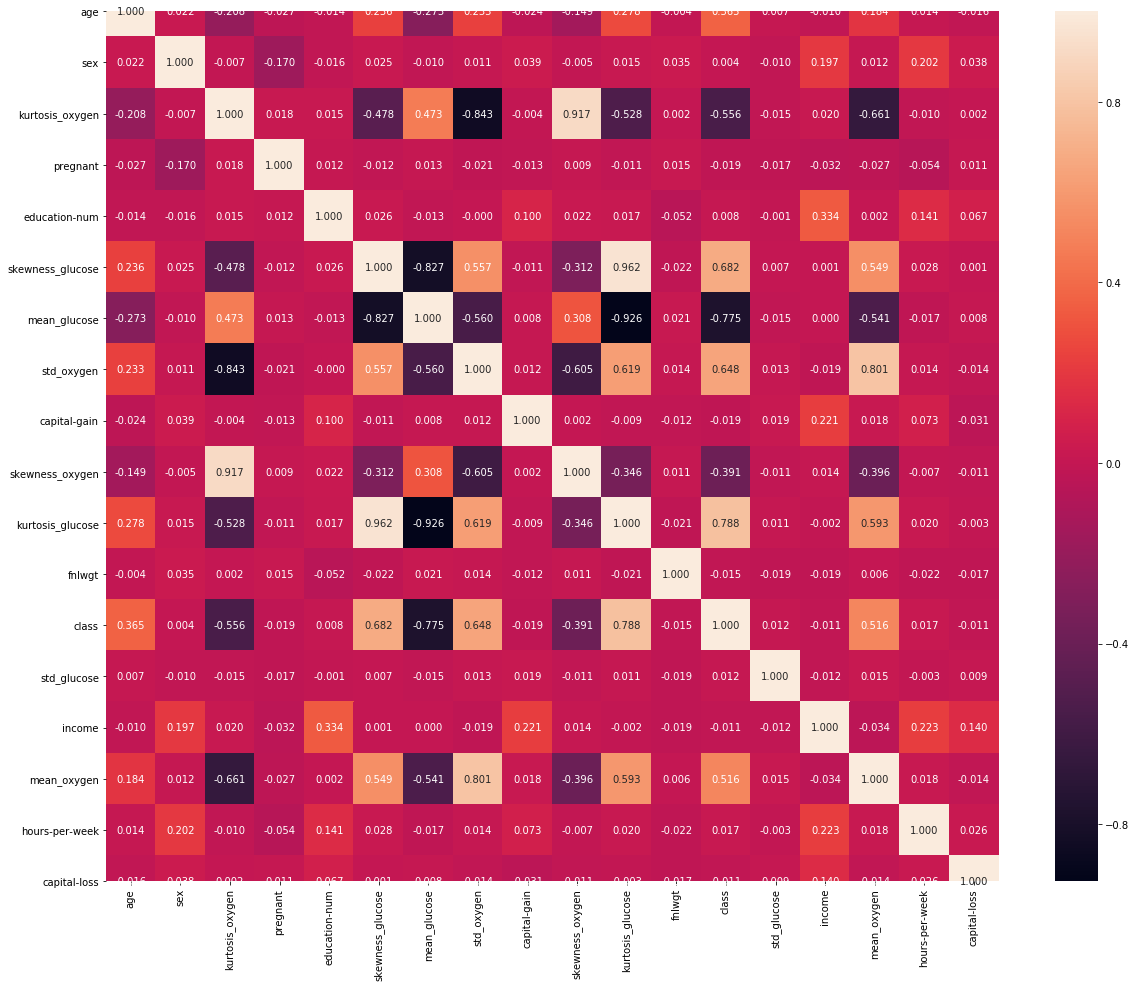

In [39]:
fig, ax = plt.subplots(figsize=(20,16))
sns.heatmap(data.corr(),ax=ax, annot =True, fmt = ".3f")

In [40]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

kurtosis_oxygen        2
pregnant               1
education-num         10
relationship           6
skewness_glucose      12
mean_glucose           4
std_oxygen            10
capital-gain           8
skewness_oxygen        5
kurtosis_glucose       7
education              6
fnlwgt                 6
class                  8
std_glucose            6
income                 7
mean_oxygen            8
hours-per-week         8
capital-loss          12
employment           238
country               74
relationship_info      4
employment_info      237
race                   9
dtype: int64

### Predikcia kurtosis oxygen na základe mean_glucose a std_glucose


In [41]:
from sklearn.preprocessing import Imputer
from sklearn import linear_model

imp_median = Imputer(missing_values='NaN', strategy='median')

C:\Users\rusna\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Ako možeme vidieť korelácie medyi atribútmi sú vysoké, takže môžeme predpokladať vyššiu úspešnosť. 

In [42]:
data['std_oxygen'] = imp_median.fit_transform(data[['std_oxygen']])
data['mean_oxygen'] = imp_median.fit_transform(data[['mean_oxygen']])
data[['kurtosis_oxygen','std_oxygen','mean_oxygen']].astype('float64').corr()



,kurtosis_oxygen,std_oxygen,mean_oxygen
kurtosis_oxygen,1.000000,-0.842162,-0.660024
std_oxygen,-0.842162,1.000000,0.801301
mean_oxygen,-0.660024,0.801301,1.000000


In [43]:
data.mean_oxygen.astype('float64').isnull().any()
data['std_oxygen'].isnull().sum()

0

In [44]:
fin = data.kurtosis_oxygen.dropna()
fin

0        5.190414
1       10.079446
2        9.967118
3       12.175754
4        0.942381
          ...    
3978    14.217960
3979    14.629993
3980     8.715394
3981    -1.283502
3982     7.162547
Name: kurtosis_oxygen, Length: 3931, dtype: float64

In [45]:
X = data[['std_oxygen','mean_oxygen']].head(fin.count())
y = fin
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
print(lm.score(X,y), 'Úspešnosť doplnenia')
missing_kurtosis_oxygen = data[['std_oxygen','mean_oxygen']].loc[data['kurtosis_oxygen'].isna()]
predictions = lm.predict(missing_kurtosis_oxygen)
predictions

0.3146106334538543 Úspešnosť doplnenia


array([9.03597604, 1.9881909 ])

In [46]:
missing = data.kurtosis_oxygen.isna()
onlyNans = data[missing]
data.loc[onlyNans.kurtosis_oxygen.index,'kurtosis_oxygen'] = predictions

In [47]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

pregnant               1
education-num         10
relationship           6
skewness_glucose      12
mean_glucose           4
capital-gain           8
skewness_oxygen        5
kurtosis_glucose       7
education              6
fnlwgt                 6
class                  8
std_glucose            6
income                 7
hours-per-week         8
capital-loss          12
employment           238
country               74
relationship_info      4
employment_info      237
race                   9
dtype: int64

Doplnenie education-num

In [48]:
data['education'] = data['education'].str.replace('-', '_')


In [49]:

data['education'].unique()

array(['HS_grad', 'Bachelors', 'Some_college', '10th', 'Assoc_acdm',
       'Masters', '1st_4th', '7th_8th', 'Prof_school', '11th', '5th_6th',
       'Assoc_voc', '9th', 'Doctorate', '12th', 'Preschool', None],
      dtype=object)

In [50]:
def minimum_positive(cond):
    mi = 11000
    for o in data['education-num'].loc[data['education'] == cond]:
        if (o > 0) & (o < mi):
            mi = o
            
    return mi

dic = {}

for a in data['education'].unique():
    dic[a] = (minimum_positive(a))
    


In [51]:
data['education-num'] = data.education.map(dic)
data['education-num'].head(10)

0     9.0
1     9.0
2    13.0
3     9.0
4    10.0
5     9.0
6     6.0
7     9.0
8    12.0
9    10.0
Name: education-num, dtype: float64

In [52]:
data['employment'].unique()

array(['Transport moving', 'Adm clerical', 'Prof specialty',
       'Tech support', None, 'Sales', 'Craft repair', 'Other service',
       'Handlers cleaners', 'Farming fishing', 'Exec managerial',
       'Machine op inspct', 'Priv house serv', 'Protective serv',
       'Armed Forces'], dtype=object)

In [53]:
# data.loc[data['employment'] == '', 'employment'].replace({data['employment_info']: np.nan})
data.loc[data['employment'].isnull(), 'employment_info'] = None

In [54]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

pregnant               1
relationship           6
skewness_glucose      12
mean_glucose           4
capital-gain           8
skewness_oxygen        5
kurtosis_glucose       7
education              6
fnlwgt                 6
class                  8
std_glucose            6
income                 7
hours-per-week         8
capital-loss          12
employment           238
country               74
relationship_info      4
employment_info      238
race                   9
dtype: int64

## Doplnenie hodnout employment_info a employment pomocou knn 

In [55]:
from sklearn.neighbors import KNeighborsClassifier

In [56]:
df = data[['education', 'education-num', 'age', 'hours-per-week', 'employment_info', 'employment']]
df

,education,education-num,age,hours-per-week,employment_info,employment
0,HS_grad,9.0,59.0,40.0,Private,Transport moving
1,HS_grad,9.0,47.0,45.0,Private,Adm clerical
2,Bachelors,13.0,59.0,40.0,Private,Prof specialty
3,HS_grad,9.0,51.0,40.0,State gov,Prof specialty
4,Some_college,10.0,81.0,16.0,Private,Tech support
...,...,...,...,...,...,...
3978,Bachelors,13.0,50.0,40.0,Private,Craft repair
3979,HS_grad,9.0,52.0,20.0,None,None
3980,11th,7.0,58.0,40.0,Private,Machine op inspct
3981,Assoc_acdm,12.0,68.0,45.0,Private,Adm clerical


In [57]:
chopped = df.dropna(axis = 0, how = "any")
chopped

,education,education-num,age,hours-per-week,employment_info,employment
0,HS_grad,9.0,59.0,40.0,Private,Transport moving
1,HS_grad,9.0,47.0,45.0,Private,Adm clerical
2,Bachelors,13.0,59.0,40.0,Private,Prof specialty
3,HS_grad,9.0,51.0,40.0,State gov,Prof specialty
4,Some_college,10.0,81.0,16.0,Private,Tech support
...,...,...,...,...,...,...
3977,Some_college,10.0,37.0,20.0,Private,Other service
3978,Bachelors,13.0,50.0,40.0,Private,Craft repair
3980,11th,7.0,58.0,40.0,Private,Machine op inspct
3981,Assoc_acdm,12.0,68.0,45.0,Private,Adm clerical


In [58]:
X = np.array(chopped.iloc[:, 1:4])
X

array([[ 9., 59., 40.],
       [ 9., 47., 45.],
       [13., 59., 40.],
       ...,
       [ 7., 58., 40.],
       [12., 68., 45.],
       [13., 60., 40.]])

In [59]:

y = np.array(chopped[['employment_info', 'employment']])
y

array([['Private', 'Transport moving'],
       ['Private', 'Adm clerical'],
       ['Private', 'Prof specialty'],
       ...,
       ['Private', 'Machine op inspct'],
       ['Private', 'Adm clerical'],
       ['Private', 'Tech support']], dtype=object)

In [60]:
example = np.array(df[['education-num', 'age', 'hours-per-week']].iloc[df.index == 3979])
print(example)

[[ 9. 52. 20.]]


In [61]:


#example = example.dropna(axis = 1, how = "any")

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X, y)

prf = knn.predict(example.reshape(1, -1))
prf

array([['Private', 'Adm clerical']], dtype=object)

In [62]:
data['age'] = data['age'].astype(int)
# data['hours-per-week'] = data['hours-per-week'].astype(int)
data['education-num'] = data['education-num'].astype(int)


data['hours-per-week'] = imp_median.fit_transform(data[['hours-per-week']])


In [63]:
# data['education-num'].iloc[df['education-num'] == 11000] = 1110
# data.loc[df['education-num'] == 11000, 'education-num'] = 11
# data['education-num'].unique()
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

pregnant               1
relationship           6
skewness_glucose      12
mean_glucose           4
capital-gain           8
skewness_oxygen        5
kurtosis_glucose       7
education              6
fnlwgt                 6
class                  8
std_glucose            6
income                 7
capital-loss          12
employment           238
country               74
relationship_info      4
employment_info      238
race                   9
dtype: int64

In [64]:
to_be_filled = data[['education', 'education-num', 'age', 'hours-per-week', 'employment_info', 'employment']].loc[data['employment_info'].isnull() == True]

dic_work = {}


to_be_filled = (to_be_filled.iloc[:, 1:4])
# to_be_filled = to_be_filled.dropna()
to_be_filled = np.array(to_be_filled)

predicted = knn.predict(to_be_filled)
predicted

array([['Private', 'Sales'],
       ['Private', 'Adm clerical'],
       ['Private', 'Exec managerial'],
       ['Private', 'Adm clerical'],
       ['Private', 'Craft repair'],
       ['Private', 'Adm clerical'],
       ['Private', 'Handlers cleaners'],
       ['Private', 'Other service'],
       ['Private', 'Exec managerial'],
       ['Private', 'Adm clerical'],
       ['Private', 'Exec managerial'],
       ['Private', 'Craft repair'],
       ['Private', 'Sales'],
       ['Private', 'Craft repair'],
       ['Private', 'Craft repair'],
       ['Private', 'Prof specialty'],
       ['Private', 'Adm clerical'],
       ['Private', 'Handlers cleaners'],
       ['Private', 'Adm clerical'],
       ['Private', 'Craft repair'],
       ['Private', 'Other service'],
       ['Private', 'Adm clerical'],
       ['Private', 'Other service'],
       ['Private', 'Sales'],
       ['Private', 'Other service'],
       ['Private', 'Craft repair'],
       ['Local gov', 'Adm clerical'],
       ['Private', 'Pr

In [65]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

pregnant               1
relationship           6
skewness_glucose      12
mean_glucose           4
capital-gain           8
skewness_oxygen        5
kurtosis_glucose       7
education              6
fnlwgt                 6
class                  8
std_glucose            6
income                 7
capital-loss          12
employment           238
country               74
relationship_info      4
employment_info      238
race                   9
dtype: int64

In [66]:

df_predicted = pd.DataFrame(predicted)
df_predicted


,0,1
0,Private,Sales
1,Private,Adm clerical
2,Private,Exec managerial
3,Private,Adm clerical
4,Private,Craft repair
5,Private,Adm clerical
6,Private,Handlers cleaners
7,Private,Other service
8,Private,Exec managerial
9,Private,Adm clerical


In [67]:
data['employment_info'].loc[data['employment_info'].isnull() == True] = df_predicted[0].values

C:\Users\rusna\Anaconda2\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [68]:
data['employment'].loc[data['employment'].isnull() == True] = df_predicted[1].values

**//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////**

In [69]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

pregnant              1
relationship          6
skewness_glucose     12
mean_glucose          4
capital-gain          8
skewness_oxygen       5
kurtosis_glucose      7
education             6
fnlwgt                6
class                 8
std_glucose           6
income                7
capital-loss         12
country              74
relationship_info     4
race                  9
dtype: int64

In [70]:
data['skewness_oxygen'].unique()

array([ 29.33438934, 119.4506868 , 119.7982303 , ...,  78.49212012,
         0.48247399,  61.69992429])

#### Doplnenie skewnes

In [71]:
import sklearn
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
df = data[['kurtosis_glucose','skewness_glucose']]
df.dropna(axis=0, how='any', inplace=True)
X = df['kurtosis_glucose'].values.reshape(-1,1)


lm.fit(X,df['skewness_glucose'])
data_T3_null = data['kurtosis_glucose'].loc[(data['skewness_glucose'].isna()) & (~data['kurtosis_glucose'].isna())]
data_T3_null
temp = lm.predict(np.array(data_T3_null).reshape(-1,1))
temp
data['skewness_glucose'].loc[(data['skewness_glucose'].isna()) & (~data['kurtosis_glucose'].isna())] = temp

C:\Users\rusna\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\rusna\Anaconda2\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


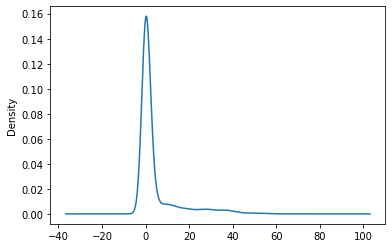

In [75]:
import copy
Zaloha = copy.deepcopy(data['skewness_glucose'])
PomDF = copy.deepcopy(data['skewness_glucose'])
PomDF.fillna(PomDF.mean(), inplace=True)
PomDF.plot(kind='kde')

In [76]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

pregnant              1
relationship          6
skewness_glucose      3
mean_glucose          4
capital-gain          8
skewness_oxygen       5
kurtosis_glucose      7
education             6
fnlwgt                6
class                 8
std_glucose           6
income                7
capital-loss         12
country              74
relationship_info     4
race                  9
dtype: int64

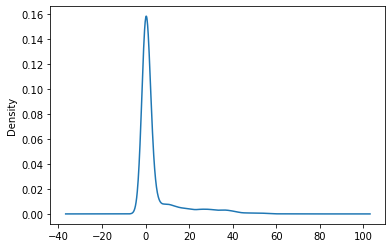

In [77]:
data['skewness_glucose'].plot(kind='kde')

In [78]:
data['skewness_glucose'].isna().sum()

3

In [79]:
linearRegressionWM = copy.deepcopy(data['skewness_glucose'])
linearRegressionWM

0      -0.043867
1       0.923553
2       0.060398
3      -0.583193
4       3.656040
          ...   
3978    2.375737
3979    0.158678
3980   -0.475804
3981    7.695857
3982    1.254641
Name: skewness_glucose, Length: 3933, dtype: float64

In [80]:
data['skewness_glucose'].fillna(data['skewness_glucose'].mean(),inplace=True)

In [81]:
data[data.columns[data.isnull().any()].tolist()].isnull().sum()

pregnant              1
relationship          6
mean_glucose          4
capital-gain          8
skewness_oxygen       5
kurtosis_glucose      7
education             6
fnlwgt                6
class                 8
std_glucose           6
income                7
capital-loss         12
country              74
relationship_info     4
race                  9
dtype: int64